### 1. Important libraries 

In [1]:
import pandas as pd # For handling data frames and performing structured data opreations. 
from tabulate import tabulate # For printing tabular data is a readable, markdown-stylee format.
import numpy as np # For numerical operations, arrays, and matrix manipulation.
import os
import matplotlib # Core plotting library.
import matplotlib.pyplot as plt # For creating static plots (e.g., bar,line,scatter).
import matplotlib.patches as mpatches # For drawing custom shapes in plots.
import seaborn as sns # For enhanced, beautiful statistical plots built on top of matplotlib.
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords #Provides tools like stopword removal, tokenization, and n-grams.
from nltk.util import ngrams

from wordcloud import WordCloud # Visualize word frequency uising a cloud of text.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Transfoorm text to numeric feature vectors.
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD # Dimensionality reduction techniques.
from sklearn.metrics import classification_report,confusion_matrix # Evaluate model performance.

from collections import defaultdict # Dictionary with default values.
from collections import Counter # Count frequency of elements (e.g., words in a document).
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re # Regular expressions for pattern-based text cleaning. 
from nltk.tokenize import word_tokenize
import gensim # Used for advanced NLP models like Word2Vec, LDA topic modeling. 
import string # Basic string operations and punctuation removal.

from tqdm import tqdm  # Display progress bars for loops and processes.
# Deep learning with TensoorFlow (Keras API)
from tensorflow.keras.preprocessing.text import Tokenizer # Prepare sequences for model input 
from tensorflow.keras.preprocessing.sequence import pad_sequences # Pad sequences for model input.
from tensorflow.keras.models import Sequential # Build a sequential neural network model.
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout # Define neural network layers for NLP.
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam # Popular optimizer for traioning neural networks.

import torch
import warnings
warnings.simplefilter('ignore')


import torch

import warnings
warnings.simplefilter('ignore')

In [2]:
# The information for columns
def inspect_df (df, name):
    info_df = pd.DataFrame({
        "Column":   df.columns,
        "Dtype":    df.dtypes.values,
        "Non-null": df.notnull().sum().values,
        "Null":     df.isnull().sum().values  
    })
    # Print structure of rows and columns
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")
    print(tabulate(info_df, headers= "keys", tablefmt="psql", showindex=False))
    
df_train = pd.read_csv("train.csv",header = None, names = ["class", "title", "text"])
df_test  = pd.read_csv("test.csv",header = None, names = ["class", "title", "text"])

# Comparison 
inspect_df(df_train, "Train")
inspect_df(df_test, "Test")
    



=== Train ===
Shape: 3600000 rows × 3 cols
+----------+---------+------------+--------+
| Column   | Dtype   |   Non-null |   Null |
|----------+---------+------------+--------|
| class    | int64   |    3600000 |      0 |
| title    | object  |    3599793 |    207 |
| text     | object  |    3600000 |      0 |
+----------+---------+------------+--------+

=== Test ===
Shape: 400000 rows × 3 cols
+----------+---------+------------+--------+
| Column   | Dtype   |   Non-null |   Null |
|----------+---------+------------+--------|
| class    | int64   |     400000 |      0 |
| title    | object  |     399976 |     24 |
| text     | object  |     400000 |      0 |
+----------+---------+------------+--------+


Check the Class distribution 

In [3]:
df_train.head(10)


,class,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,2,an absolute masterpiece,I am quite sure any of you actually taking the...
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...


### Class distribution

### Sentiment Class Distribution 
To understand the structure of the training set, we first conducted an EDA on the sentiment labels. The dataset includes two sentiment classes: From introduction of the dataset

· Class 1: Negative reviews

· Class 2: Positive reviews

The following bar chart shows the distribution of sentiment labels in the training set: 
From the chart, we observe that each class contains 1,800,800 reviews, which means the dataset is a balanced dataset. This ideal for classification tasks, as a balanced class distribution helps prevent bias toward one class during training. 

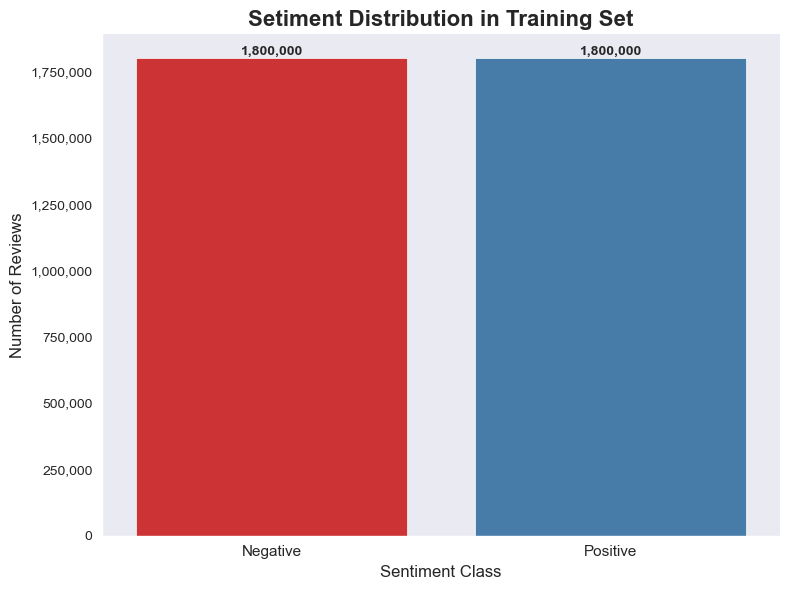

In [4]:
# Set the visual style 
sns.set_style('dark')
plt.figure(figsize= (8,6))

# Draw the count plot for sentiment classes
ax = sns.countplot(data = df_train, x = 'class', palette= 'Set1')

# Set title and axis labels 
plt.title ('Setiment Distribution in Training Set', fontsize = 16, fontweight = 'bold')
plt.xlabel("Sentiment Class", fontsize = 12)
plt.ylabel('Number of Reviews', fontsize = 12)


# Rename x-axis ticks labels for better interpretation 
ax.set_xticklabels(['Negative', 'Positive'] , fontsize = 11)

# Format y-axis ticks with thousands separator (e.g., 1,800,000)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()



###  Number of characters in training set
This plot compares the distribution of review lengths (in characters) between negative (class 1) and positive (class 2) Amazon reviews. It helps us understand whether review length varies significantly across sentiment classes.

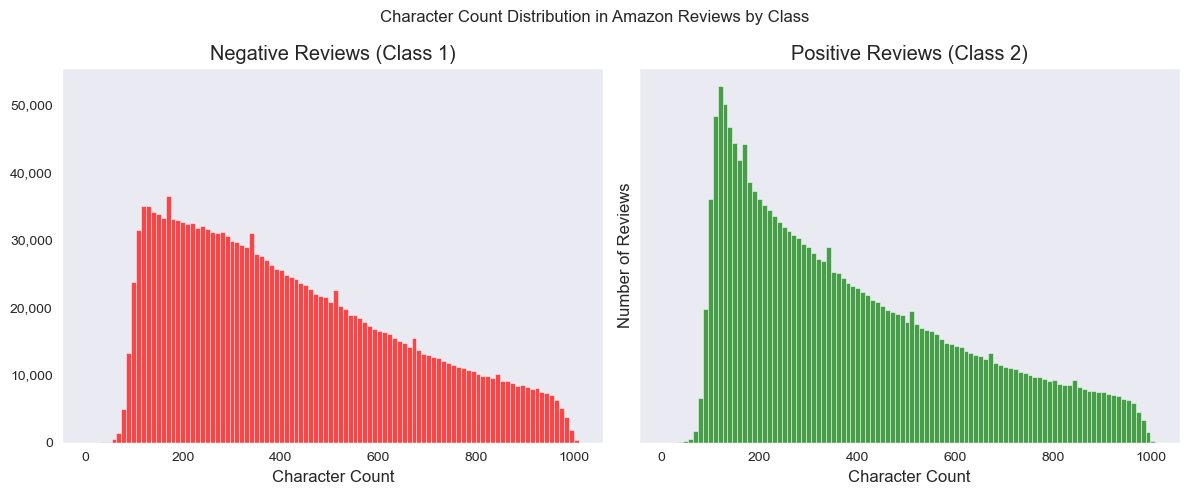

In [5]:
# Function to calculate length of each review
def get_length(text):
    return len(text)

# Create a new column 'length' in training set
df_train['length'] = df_train['text'].apply(get_length)

# Create two subsets for plotting
negative_reviews= df_train[df_train['class'] == 1]['length']
positive_reviews= df_train[df_train['class'] == 2]['length']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
thousands_fmt = FuncFormatter(lambda x, p: f'{int(x):,}')

# Plot histogram for positive reviews
ax2.hist(positive_reviews, bins=100, color='green', alpha=0.7)
ax2.set_title('Positive Reviews (Class 2)')
ax2.set_xlabel('Character Count')
ax2.set_ylabel('Number of Reviews')
ax2.yaxis.set_major_formatter(thousands_fmt)
# Plot histogram for negative reviews
ax1.hist(negative_reviews, bins=100, color='red', alpha=0.7)
ax1.set_title('Negative Reviews (Class 1)')
ax1.set_xlabel('Character Count')
ax1.yaxis.set_major_formatter(thousands_fmt)

# Add overall title
fig.suptitle('Character Count Distribution in Amazon Reviews by Class')
plt.tight_layout()
plt.show()


# Analysis of Character Count Distribution in Training Set 

### 1. Right-skewed Distribution

Both negative (Class 1) and negative (Class 2) reviews exhibit a right-skewed distribution. The majority of reviews are relatively short, typically ranging between 150 and 350 characters, while long reviews are rare.

### 2. Frequency Observation 

Although the shape of both distributions is quite similar, positive reviews tend to be slightly more frequent in the peak region than negative ones, suggesting users may write slightly shorter texts when expressing satisfaction.

### 3. Presence of Outliers

Both classes include a small number of very long reviews (exceeding 800 characters), which may be considered outliers and could need special treatment during preprocessing.
   

# Word count 

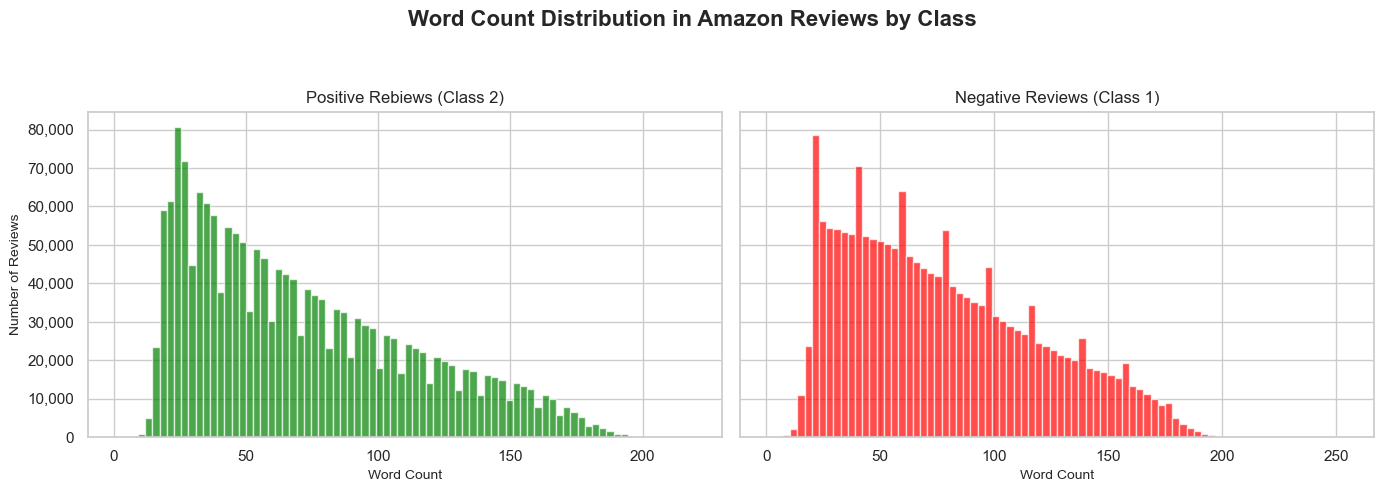

In [6]:
# Use Seaborn's built-in theme (white + grid)
sns.set_theme(style = "whitegrid")

# Compute word counts
df_train['word_count'] = df_train['text'].astype(str).apply(lambda s : len(s.split()))

# Split into two classes 
positive = df_train[df_train['class'] == 2]['word_count']
negative = df_train[df_train['class'] == 1]['word_count']

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (14,5), sharey = True)
fig.suptitle('Word Count Distribution in Amazon Reviews by Class', fontsize = 16, fontweight ='bold')

# Thousands-separator formatter
fmt = FuncFormatter(lambda x,_:f"{int(x):,}")

# Plot Positive Reviews 
ax1.hist(positive, bins = 80, color = 'green', alpha = 0.7)
ax1.set_title('Positive Rebiews (Class 2)', fontsize = 12)
ax1.set_xlabel('Word Count', fontsize = 10)
ax1.set_ylabel('Number of Reviews', fontsize = 10)
ax1.yaxis.set_major_formatter(fmt)

# Plot Negative Reviews
ax2.hist(negative,bins = 80, color ='red',alpha = 0.7)
ax2.set_title('Negative Reviews (Class 1)', fontsize = 12)
ax2.set_xlabel('Word Count', fontsize = 10)
ax2.yaxis.set_major_formatter

plt.tight_layout(rect=[0,0,1,0.93])
plt.show()

### Average average word count by class


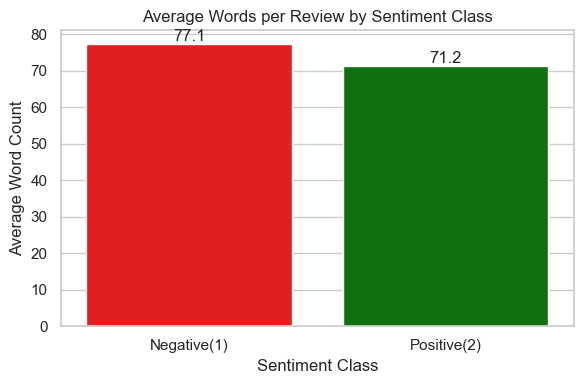

In [7]:
# Make sure you have word counts: 
mean_counts = df_train.groupby('class')['word_count']\
    .mean()\
        .reset_index()

# Plot the averages 
plt.figure(figsize = (6,4))
ax = sns.barplot(
    data = mean_counts,
    x='class',
    y='word_count',
    palette=['red','green']
)

ax.set_xticklabels(['Negative(1)', 'Positive(2)'])
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Average Word Count')
ax.set_title('Average Words per Review by Sentiment Class')

# Annotate bars with the numeric values (rounded)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}',
                (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom')
plt.tight_layout()
plt.show()        

### Common stopwords

{'his', "she's", 'yourself', 'where', 'them', 'to', 'shan', 'd', 'll', "he's", 'should', 'not', 'until', 'aren', 'ain', 'has', "they'd", 'with', 'there', 'was', 'out', "we're", 's', 'our', 'into', "you're", 'wouldn', 'they', 'it', 'of', "needn't", 'who', 'while', 'whom', 'now', 'its', 'yours', 'and', "isn't", "you've", 'o', "wouldn't", "you'd", 'these', "hadn't", "it'll", "they're", 'couldn', 'both', 'are', 'through', 'than', 'do', 'again', 'am', 'herself', 'doing', 'himself', 'i', 'below', "it's", 'all', 'other', 'he', 'which', 'why', 'hers', "i'd", 'have', "it'd", 'so', 'over', 'isn', "don't", 'then', 'down', 'me', 'their', "doesn't", 'her', 'some', 'theirs', 'wasn', 'by', 'because', 'hadn', 'she', 'an', 'few', 'on', 'those', "won't", 'ma', "that'll", "should've", 'if', 'how', "weren't", 'about', 'above', 'a', "they've", 'during', "he'd", 'further', 'more', 'for', 'having', "we'll", 'your', 'that', "shouldn't", 'between', 'before', 'too', 'themselves', 'this', 'being', 'we', 'hasn', 

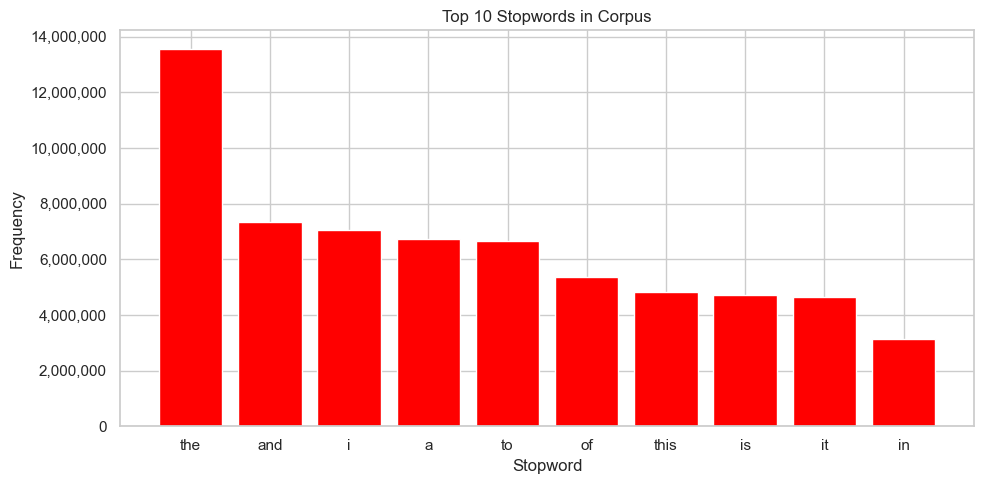

In [8]:
import nltk
from nltk.corpus import stopwords

# Load English stopwords
stop = set(stopwords.words('english'))

# Create corpus 
corpus =[]
for x in df_train['text'].astype(str).str.split():
    for i in x:
        corpus.append(i.lower())  # All of words are lower case

# Calculate the frequences of stopwords 
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

# Frequency ranking (by descending)
top_stopwords = sorted(dic.items(), key = lambda x: x[1], reverse = True)
# Select top 10
top10 = top_stopwords [:10]

# The stopwords
found_stopwords = set (word for word in corpus if word in stop)
print(found_stopwords)
# Plot 
plt.figure(figsize = (10,5))
x,y = zip(*top10)
plt.bar(x,y,color = 'red')
plt.title("Top 10 Stopwords in Corpus")
plt.xlabel("Stopword")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()


# Analyzing punctuations 

{'}', '^_', '?', '%', '/', '=>', './', '\\', '<', '-.', '+,-', ',', ':', "'(", '"#', '.', '-', '!"', "'", '=', '$', '~', '|', '()', '<=', '+', '!', '*', '+,', ';', '`', ']', ')', '_', '[', '#$%&', ',-', '[\\]', '<=>', '@', '"', '>', ')*', '(', '{', '#$%', '/:', '^', '#', '&'}


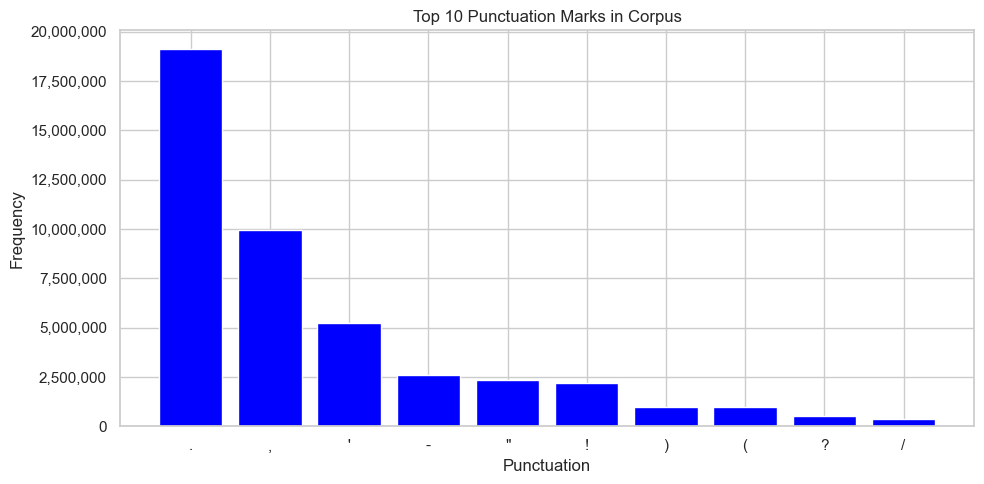

In [9]:
# Cropus function 
corpus1 = []
for x in df_train['text'].astype(str):
    for char in x: 
        corpus.append(char)

# Calculate the frequencies of punctuation marks
dic = defaultdict(int)
for char in corpus:
    if char in string.punctuation:
        dic[char] += 1

# Frequency ranking (by descending)
top_punct = sorted(dic.items(), key=lambda x: x[1], reverse = True)
# Select top 10
top10 = top_punct[:10]

# The punctuation symbols found 
found_punct = set(char for char in corpus if char in string.punctuation)
print(found_punct)

# Plot 
plt.figure(figsize = (10, 5))
x, y =zip(*top10)
plt.bar(x,y, color = 'blue')
plt.title("Top 10 Punctuation Marks in Corpus")
plt.xlabel("Punctuation")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()



### N-gram analysis

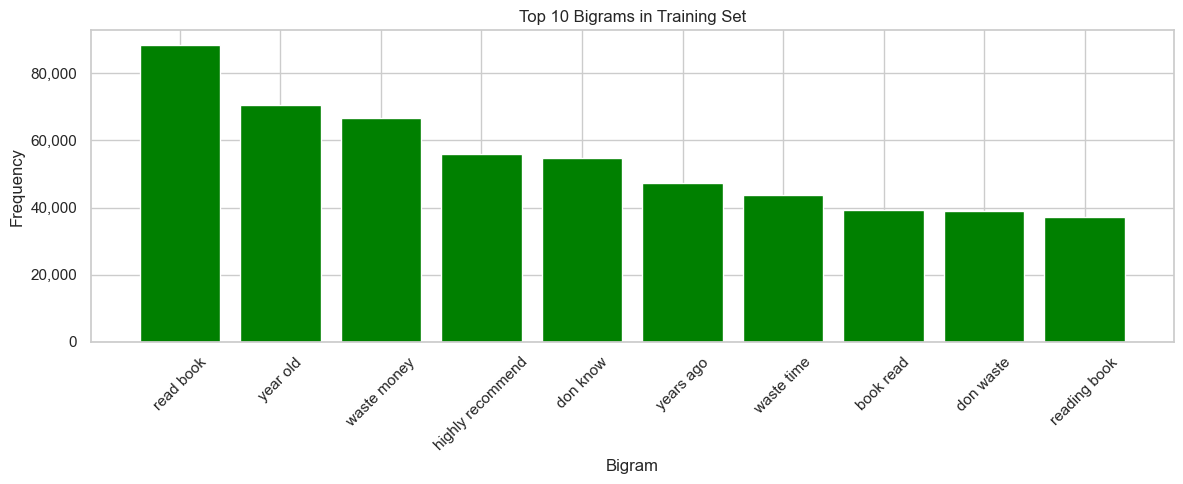

In [10]:
# Initialize a CountVectorizer with bigram (n=2)
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fit and transform the training text data
X = vectorizer.fit_transform(df_train['text'].astype(str))

# Sum the frequencies of each bigram
sum_words = X.sum(axis=0)
bigram_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# Sort bigrams by frequency
sorted_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Select top 10
top10 = sorted_bigrams[:10]

x, y = zip(*top10)
plt.figure(figsize=(12, 5))
bars = plt.bar(x, y, color='green')
plt.title("Top 10 Bigrams in Training Set")
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))


plt.tight_layout()
plt.show()
